In [1]:
import cnot_network

from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sbs
import numpy as np
sbs.set_context("paper")
sbs.set_theme()
sbs.set_style("dark")

from surface_code_routing.tikz_utils import tikz, tex

sbs.set_style("whitegrid", {'grid.linestyle': '-.'})

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

def plt_data(condition, x_axis, y_axis, target=None):
    data = filter(lambda x: x[0] == target, zip(condition, x_axis, y_axis))
    x = []
    y = []
    for _, x_val, y_val in data:
        x.append(x_val)
        y.append(y_val)
    return {'x':x, 'y':y}

def plt_data_multi(data, x_axis, y_axis, **targets):
    idx_map = {j:i for i, j in enumerate(data)}
    rev_map = {j:i for i, j in idx_map.items()}

    iters = zip(*[iter(data[rev_map[i]]) for i, _ in enumerate(data)])

    x = []
    y = []
    for it in iters:
        checks = True
        for targ in targets:
            if it[idx_map[targ]] != targets[targ]:
                checks = False
        if not checks:
            continue
            
        x.append(it[idx_map[x_axis]])
        y.append(it[idx_map[y_axis]])
    return {'x':x, 'y':y}

In [2]:
from surface_code_routing.dag import DAG
from surface_code_routing.symbol import Symbol 
from surface_code_routing.instructions import INIT, CNOT, MEAS, X, Hadamard, SWAP
from surface_code_routing.lib_instructions import T_Factory, CSWAP
from surface_code_routing.compiled_qcb import compile_qcb

In [3]:
import cnot_network
from functools import partial
from surface_code_routing.lib_instructions import T_Factory, Toffoli, T_gate

toff_height = 14
toff_width = toff_height

t_factory_l1 = cnot_network.T_Factory()
toffoli_gate = cnot_network.Toffoli

t_factory_l2 = T_Factory(t_factory_l1, height=8, width=10, t_gate=T_gate(t_factory_l1))
t_gate_l2 = T_gate(factory=t_factory_l2)

t_factory_l3 = T_Factory(t_factory_l2, height=11, width=12, t_gate=T_gate(t_factory_l2))
t_gate_l3 = T_gate(factory=t_factory_l3)

extern_toffoli_l1 = cnot_network.toffoli(toff_height, toff_width, t_factory=t_factory_l1)
extern_toffoli_l2 = cnot_network.toffoli(toff_height, toff_width, t_factory=t_factory_l2)
extern_toffoli_l3 = cnot_network.toffoli(toff_height, toff_width, t_factory=t_factory_l3)

# Raw T injection sites
ccz_factory_l1 = cnot_network.CCZ_factory(6, 4, t_factory=None)
ccz_factory_l2 = cnot_network.CCZ_factory(9, 7, t_factory=t_factory_l1)
ccz_factory_l3 = cnot_network.CCZ_factory(11, 11, t_factory=t_factory_l2)

t_factories = (t_factory_l1, t_factory_l2, t_factory_l3)
extern_toffolis = (extern_toffoli_l1, extern_toffoli_l2, extern_toffoli_l3)
ccz_factories = (ccz_factory_l1, ccz_factory_l2, ccz_factory_l3)

In [4]:
toffoli = partial(Toffoli, T=T_gate(factory=t_factory_l1))

toffoli = cnot_network.toff_extern(extern_toffoli_l1)

toffoli = partial(cnot_network.toffoli_from_ccz, ccz_factory=ccz_factory_l1)

In [5]:
def qram_fanout(address_size,
                line_width,
                height,
                width,
                *externs,
                CSWAP=CSWAP,
                readout=CNOT,
                compile=True,
                **compiler_args):

    dag = DAG(Symbol('qram_fanout', ['query_{i}'.format(i=i) for i in range(address_size)] , ['readout_{i}'.format(i=i) for i in range(line_width)]))

    for target_anc in range(1 << address_size):
        for memory_index in range(line_width):
            dag.add_gate(INIT(f'mem_{target_anc}_{memory_index}'))

    for target_anc in range(address_size):
        dag.add_gate(INIT(f'anc_{target_anc}'))

    # Fanout
    for addr_bit in range(address_size):
        mask = 1 << addr_bit
        target_ancillae = list(filter(lambda x: x % mask == 0, range(1 << address_size)))
        
        dag.add_gate(CNOT(f'query_{addr_bit}', *list(map(
            lambda x: 'anc_{i}'.format(i=x), target_ancillae
            ))))

        for anc_a, anc_b in zip(target_ancillae[::2], target_ancillae[1::2]): 
            for memory_index in range(line_width):
                dag.add_gate(CSWAP(f'anc_{anc_a}', f'mem_{anc_a}_{memory_index}', f'mem_{anc_b}_{memory_index}'))

        dag.add_gate(CNOT(f'query_{addr_bit}', *list(map(
            lambda x: 'anc_{i}'.format(i=x), target_ancillae
            ))))

    # Readout
    for index in range(line_width):
        dag.add_gate(readout(f'mem_0_{index}', f'readout_{index}'))

    # Fan-in
    for addr_bit in range(address_size - 1, -1, -1):
        mask = 1 << addr_bit
        target_ancillae = list(filter(lambda x: x % mask == 0, range(1 << address_size)))
        
        dag.add_gate(CNOT(f'query_{addr_bit}', *list(map(
            lambda x: 'anc_{i}'.format(i=x), target_ancillae
            ))))

        for anc_a, anc_b in zip(target_ancillae[::2], target_ancillae[1::2]): 
            for memory_index in range(line_width):
                dag.add_gate(CSWAP(f'anc_{anc_a}', f'mem_{anc_a}_{memory_index}', f'mem_{anc_b}_{memory_index}'))


        dag.add_gate(CNOT(f'query_{addr_bit}', *list(map(
            lambda x: 'anc_{i}'.format(i=x), target_ancillae
            ))))

    if compile:
        return compile_qcb(dag, height, width, *externs, **compiler_args) 
    return dag

In [7]:
ccz_toffoli_gate = partial(cnot_network.toffoli_from_ccz, ccz_factory=ccz_factory_l1)
cswap = partial(CSWAP, Toffoli=ccz_toffoli_gate)

In [8]:
from functools import partial
results = {'height':[], 'distillery':[], 'volume':[], 'runtime':[], 'address':[], 'width':[]}
sizes = [16, 32, 48, 64]

ccz_toffoli_gate = partial(cnot_network.toffoli_from_ccz, ccz_factory=ccz_factory_l1)
cswap = partial(CSWAP, Toffoli=ccz_toffoli_gate)
z
min_reg = 1
max_reg = 8

for addr in range(min_reg, max_reg + 1):
    for size in sizes:
        for width in (1, 2):
            for distillery, extern in zip((1, 2, 3), ccz_factories):
                print(f"\r Compiling: {addr} {size} {distillery}" + " " * 5, flush=True, end='')
                try:
                    qcb = qram_fanout(addr, width, size, size, extern, CSWAP=cswap)
                    results['height'].append(size)
                    results['width'].append(width)
                    results['distillery'].append(distillery)
                    results['volume'].append(qcb.space_time_volume())
                    results['runtime'].append(qcb.n_cycles())
                    results['address'].append(addr)
                    del qcb
                except: # This will likely be an allocation size issue
                    pass
        
results_fanout = results

 Compiling: 8 64 3     

In [9]:
print(results)

{'height': [16, 16, 16, 16, 16, 16, 32, 32, 32, 32, 32, 32, 48, 48, 48, 48, 48, 48, 64, 64, 64, 64, 64, 64, 16, 16, 16, 16, 16, 16, 32, 32, 32, 32, 32, 32, 48, 48, 48, 48, 48, 48, 64, 64, 64, 64, 64, 64, 16, 16, 16, 16, 16, 16, 32, 32, 32, 32, 32, 32, 48, 48, 48, 48, 48, 48, 64, 64, 64, 64, 64, 64, 16, 16, 16, 16, 16, 16, 32, 32, 32, 32, 32, 32, 48, 48, 48, 48, 48, 48, 64, 64, 64, 64, 64, 64, 16, 16, 16, 16, 32, 32, 32, 32, 32, 32, 48, 48, 48, 48, 48, 48, 64, 64, 64, 64, 64, 64, 32, 32, 32, 32, 32, 32, 48, 48, 48, 48, 48, 48, 64, 64, 64, 64, 64, 64, 32, 32, 32, 32, 32, 32, 48, 48, 48, 48, 48, 48, 64, 64, 64, 64, 64, 64, 32, 32, 32, 48, 48, 48, 48, 48, 48, 64, 64, 64, 64, 64, 64], 'distillery': [1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 1,

In [6]:
results_fanout = {'height': [16, 16, 16, 16, 16, 16, 32, 32, 32, 32, 32, 32, 48, 48, 48, 48, 48, 48, 64, 64, 64, 64, 64, 64, 16, 16, 16, 16, 16, 16, 32, 32, 32, 32, 32, 32, 48, 48, 48, 48, 48, 48, 64, 64, 64, 64, 64, 64, 16, 16, 16, 16, 16, 16, 32, 32, 32, 32, 32, 32, 48, 48, 48, 48, 48, 48, 64, 64, 64, 64, 64, 64, 16, 16, 16, 16, 16, 16, 32, 32, 32, 32, 32, 32, 48, 48, 48, 48, 48, 48, 64, 64, 64, 64, 64, 64, 16, 16, 16, 16, 32, 32, 32, 32, 32, 32, 48, 48, 48, 48, 48, 48, 64, 64, 64, 64, 64, 64, 32, 32, 32, 32, 32, 32, 48, 48, 48, 48, 48, 48, 64, 64, 64, 64, 64, 64, 32, 32, 32, 32, 32, 32, 48, 48, 48, 48, 48, 48, 64, 64, 64, 64, 64, 64, 32, 32, 32, 48, 48, 48, 48, 48, 48, 64, 64, 64, 64, 64, 64], 'distillery': [1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3], 'volume': [1628, 32970, 750904, 3027, 68742, 1646225, 2393, 32643, 709580, 3595, 65181, 1437500, 1965, 31424, 714713, 3807, 65229, 1433188, 3808, 32868, 696169, 4564, 65796, 1429246, 5508, 108318, 2690715, 13042, 237820, 5839243, 6514, 98586, 2233063, 11985, 210304, 4550042, 7609, 95338, 2142569, 12561, 199247, 4439128, 6871, 98577, 2141855, 14330, 197959, 4388161, 13628, 302271, 7410954, 27465, 667001, 17267072, 15616, 237334, 5539317, 31270, 477387, 11586435, 17180, 231747, 5024217, 37152, 471981, 10257037, 17971, 243712, 5052813, 38399, 466413, 10216917, 34533, 762780, 19777239, 82511, 2837716, 46836648, 34215, 553502, 13186791, 71065, 1182597, 29103035, 43114, 534427, 11232623, 81551, 1024592, 22637404, 50307, 542404, 11044893, 97995, 1157137, 23635893, 253834, 3437899, 598791, 8372202, 79978, 1237712, 34018449, 163860, 2948539, 71445494, 92010, 1220837, 25645441, 187608, 2282908, 54016090, 109362, 1248546, 25597578, 229978, 2344881, 47585074, 198020, 3305254, 94578204, 501473, 10301819, 245331147, 222788, 2940110, 58528175, 474925, 5382691, 124736181, 250303, 3138589, 60535763, 476024, 5548642, 137127945, 560865, 11186855, 258917967, 1633000, 31653479, 1698786499, 636197, 7062395, 157468546, 1500074, 13090842, 359702461, 671081, 8874454, 149042269, 1649501, 22612757, 243176873, 10561972, 136895104, 2063176142, 1914559, 23767994, 388424352, 4708550, 69543935, 1518472600, 2069178, 20845438, 358439537, 5478085, 40904539, 749997340], 'runtime': [37, 480, 14002, 67, 954, 28011, 38, 328, 4679, 62, 646, 9346, 40, 328, 4677, 68, 642, 9345, 36, 325, 4682, 62, 640, 9349, 83, 1431, 42012, 162, 2845, 84036, 78, 505, 11682, 127, 974, 21030, 80, 503, 7032, 131, 975, 14028, 71, 501, 7027, 118, 968, 14026, 189, 3331, 98034, 316, 6655, 196086, 118, 801, 25681, 202, 1312, 49030, 121, 799, 11681, 195, 1294, 21023, 111, 797, 11679, 193, 1160, 21024, 346, 7158, 210101, 709, 28480, 420223, 208, 1902, 53693, 355, 3647, 105080, 183, 1471, 21063, 296, 1902, 35073, 181, 1460, 21057, 313, 2881, 42066, 2483, 29454, 4890, 58912, 334, 3361, 109711, 499, 7448, 217160, 323, 3035, 44375, 474, 3074, 88705, 311, 3028, 44372, 563, 3062, 44404, 614, 7600, 294107, 1264, 24007, 588238, 579, 6034, 88744, 947, 6397, 147114, 566, 6020, 88724, 739, 6087, 177408, 1172, 24219, 592912, 2855, 60596, 3557215, 1111, 12195, 198442, 2139, 12835, 396809, 1114, 12156, 179727, 2144, 24226, 179752, 20141, 241832, 3571281, 2173, 24256, 396865, 4268, 69480, 1428522, 2184, 24334, 357213, 4204, 24339, 448164], 'address': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8], 'width': [1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2]}

Text(0.5, 0.01, '$2^n$ Address Bucket Brigade QRAM')

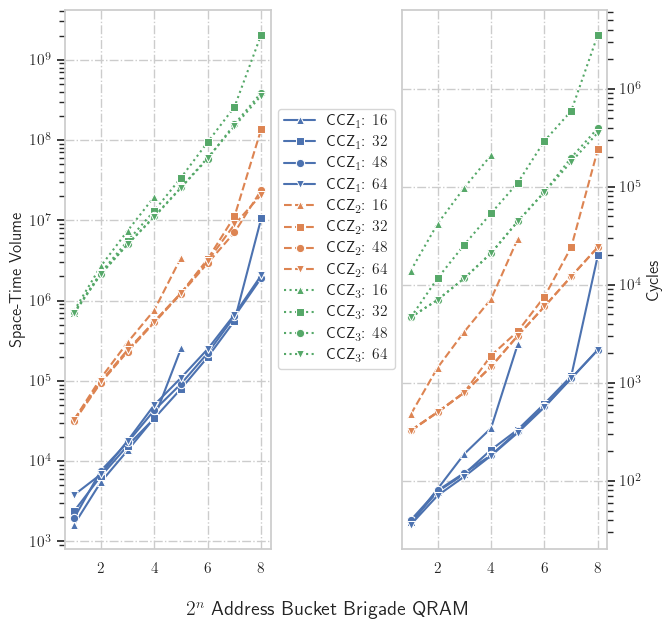

In [8]:
sizes = [16, 32, 48, 64]
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

#f, ax = plt.subplots(figsize=(7, 7))


sbs.set_theme()
sbs.set_style("dark")
sbs.set_style("whitegrid", {'grid.linestyle': '-.'})

#locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=20)  
#ax.yaxis.set_minor_locator(locmin)
#ax.yaxis.set_minor_formatter(mticker.NullFormatter())
#plt.grid(True,which="both")  


marks = ['^', 's', 'o', 'v']
linestyles = ['-', '--', ':']

target_key = 'distillery'
dependent = 'volume'
independent = 'address'
#fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 7))

ax = [
    plt.subplot2grid((1, 5), (0, 0), colspan=2),
    plt.subplot2grid((1, 5), (0, 3), colspan=2)
]

subplot = ax[0]
kwargs = {
'errorbar':('ci', 100)
}

for idx, target in enumerate((1, 2, 3)):
    for jdx, size in enumerate(sizes):
        obj = sbs.lineplot(
            ax=subplot,
            **plt_data_multi(
                results_fanout,
                independent,
                dependent,
                height=size,
                width=1,
                distillery=target
            ),
            label=f'CCZ$_{target}$: ${size}$',
            linestyle=linestyles[idx],
            marker=marks[jdx],
            color=sbs.color_palette()[idx],
            **kwargs
        )
subplot.legend_.remove()
subplot.yaxis.set_label_position("left")
subplot.yaxis.tick_left()
subplot.set_yscale('log')
subplot.set_ylabel('Space-Time Volume')

dependent = 'runtime'

subplot = ax[1]
for idx, target in enumerate((1, 2, 3)):

    for jdx, size in enumerate(sizes):
        obj = sbs.lineplot(
            ax=subplot,
            **plt_data_multi(
                results_fanout,
                independent,
                dependent,
                height=size,
                width=1,
                distillery=target
            ),
            label=f'CCZ$_{target}$: ${size}$',
            linestyle=linestyles[idx],
            marker=marks[jdx],
            color=sbs.color_palette()[idx],
            **kwargs
        )
    
subplot.legend_.remove()
subplot.yaxis.set_label_position("right")
subplot.yaxis.tick_right()
subplot.set_yscale('log')
subplot.set_ylabel('Cycles')

fig = plt.gcf()
fig.set_size_inches(7, 7)

lines = linestyles * 3
labels = sum(([f'DAG$_{target}$', f'Extern$_{target}$', f'CCZ$_{target}$'] for target in range(3)), start=list())

handles, labels = subplot.get_legend_handles_labels()
plt.figlegend(handles, labels, loc='upper left', bbox_to_anchor=(0.419, 0.75))
fig.supxlabel('$2^n$ Address Fanout QRAM')

plt.savefig('fanout.pdf')